In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#PHASE 1: data collection
# --- Step 1: Define NSE and NYSE IT stocks ---
tickers_nse = ['INFY.NS', 'TCS.NS', 'WIPRO.NS', 'DRREDDY.NS', 'HCLTECH.NS']
tickers_nyse = ['MSFT', 'AAPL', 'CSCO', 'ORCL', 'IBM']

start = "2020-01-01"
end = "2025-05-01"
nse_data = yf.download(tickers_nse, start=start, end=end, group_by='ticker', auto_adjust=True)
nyse_data = yf.download(tickers_nyse, start=start, end=end, group_by='ticker', auto_adjust=True)
def extract_close(df, tickers):
    close_prices = pd.DataFrame()
    for ticker in tickers:
        if isinstance(df.columns, pd.MultiIndex):
            close_prices[ticker] = df[ticker]['Close']
        else:
            close_prices[ticker] = df['Close']
    return close_prices

nse_close = extract_close(nse_data, tickers_nse)
nyse_close = extract_close(nyse_data, tickers_nyse)
combined_prices = pd.concat([nse_close, nyse_close], axis=1, join='inner')
combined_prices.dropna(inplace=True)



print("Combined clean price data:\n")
print(combined_prices.head())


[*********************100%***********************]  5 of 5 completed

5 Failed downloads:
['TCS.NS', 'INFY.NS', 'WIPRO.NS', 'DRREDDY.NS', 'HCLTECH.NS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  5 of 5 completed

5 Failed downloads:
['MSFT', 'CSCO', 'IBM', 'AAPL', 'ORCL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Combined clean price data:

Empty DataFrame
Columns: [INFY.NS, TCS.NS, WIPRO.NS, DRREDDY.NS, HCLTECH.NS, MSFT, AAPL, CSCO, ORCL, IBM]
Index: []


In [6]:
# Normalize the prices to start at 100
normalized_prices = combined_prices / combined_prices.iloc[0] * 100

# Reset index for seaborn (it needs columns, not datetime index)
normalized_prices_reset = normalized_prices.reset_index().melt(id_vars='Date', 
                                                               var_name='Stock', 
                                                               value_name='Normalized Price')

#lineplot
plt.figure(figsize=(14, 7))
sns.lineplot(data=normalized_prices_reset, x='Date', y='Normalized Price', hue='Stock')

plt.title("Normalized Stock Prices (2020–2025): NSE & NYSE IT Sector")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Start = 100)")
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


IndexError: single positional indexer is out-of-bounds

c:\Users\Aditya Dwaraki Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Aditya Dwaraki Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Aditya Dwaraki Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this 

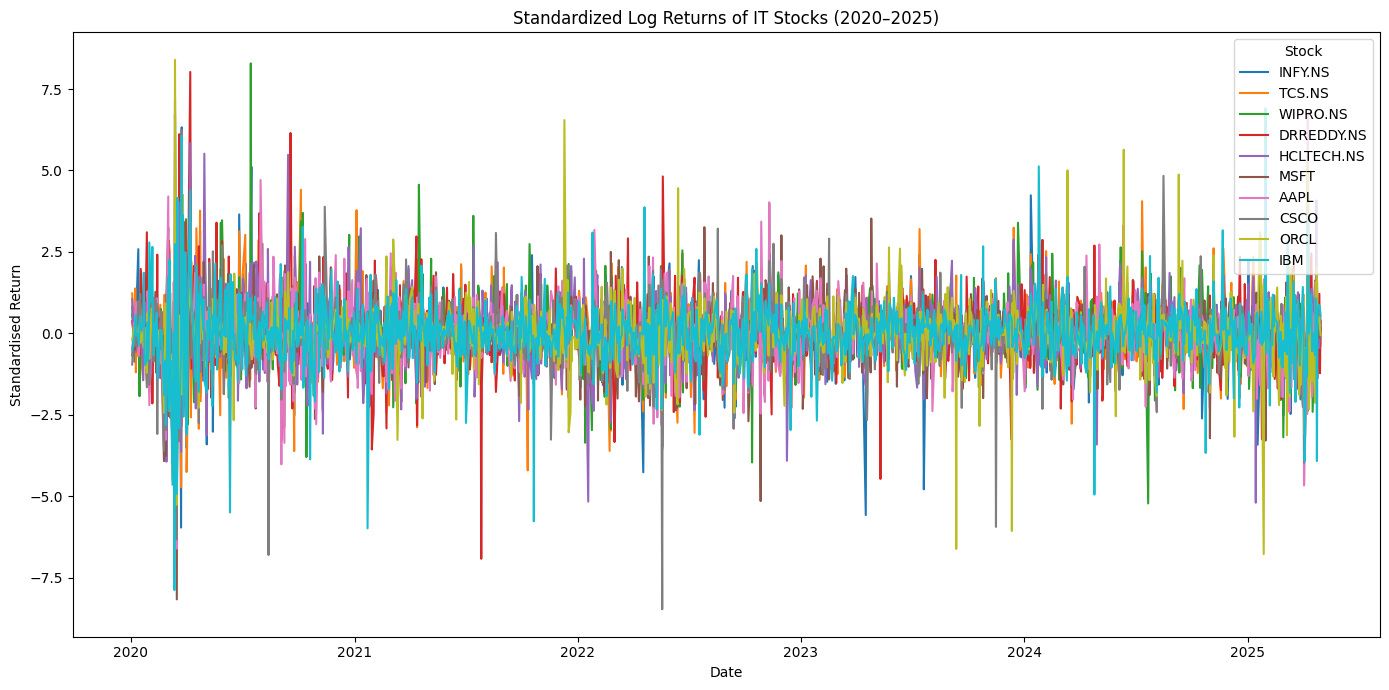

In [ ]:
#PHASE 2: EDA
#log returns
returns = np.log(combined_prices/combined_prices.shift(1)).dropna()

scaler = StandardScaler()
returns_scaled = pd.DataFrame(scaler.fit_transform(returns),
                              columns = returns.columns,
                              index = returns.index)

#plotting the returns
returns_melted  = returns_scaled.reset_index().melt(id_vars = "Date",
                                                     var_name = "Stock",
                                                     value_name = "Standardised Return")

plt.figure(figsize = (14,7))
sns.lineplot(data = returns_melted, x = "Date", y = "Standardised Return", hue = "Stock")
plt.title("Standardized Log Returns of IT Stocks (2020–2025)")
plt.tight_layout()
plt.show()


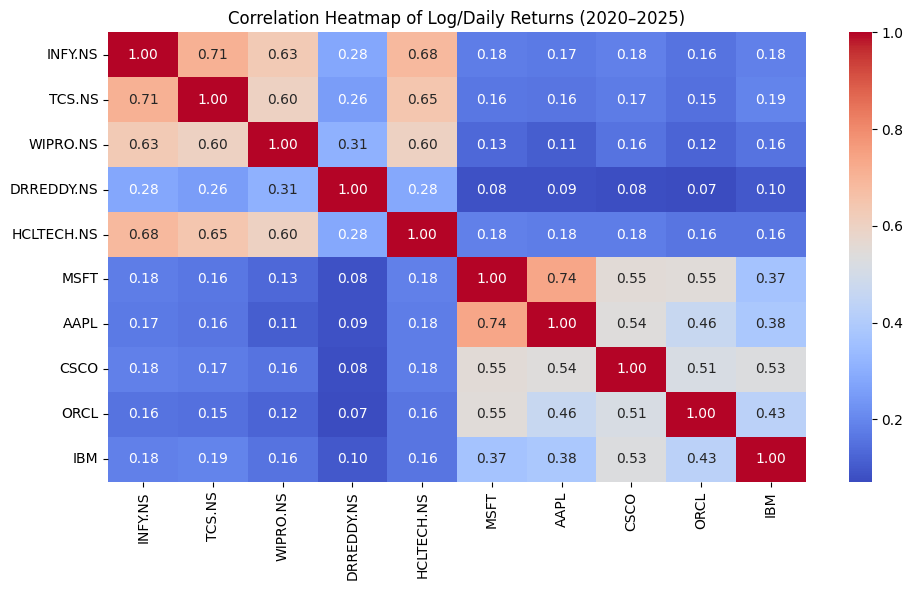

In [ ]:
#PHASE 2: EDA(continued)
# Correlation heatmap
plt.figure(figsize = (10,6))
sns.heatmap(returns.corr(),annot = True,cmap = "coolwarm",fmt = ".2f")
plt.title("Correlation Heatmap of Log/Daily Returns (2020–2025)")
plt.tight_layout()
plt.show()


In [ ]:
# Unstack and sort correlation matrix (excluding self-pairs)
corr_matrix = returns.corr().unstack().sort_values(ascending=False)

# Filter only cross-market pairs (NSE-NYSE)
nse_stocks = [s for s in returns.columns if '.NS' in s]
nyse_stocks = [s for s in returns.columns if '.NS' not in s]

cross_pairs = [(a, b) for a, b in corr_matrix.index if (a in nse_stocks and b in nyse_stocks)]
top_pairs = [(a, b, corr_matrix[(a, b)]) for a, b in cross_pairs[:5]]

print("Top 5 NSE-NYSE correlated stock pairs:")
for a, b, corr in top_pairs:
    print(f"{a} - {b}: {corr:.2f}")


Top 5 NSE-NYSE correlated stock pairs:
TCS.NS - IBM: 0.19
INFY.NS - IBM: 0.18
HCLTECH.NS - MSFT: 0.18
INFY.NS - CSCO: 0.18
HCLTECH.NS - CSCO: 0.18


The above results help us , a low or slight negative corelation helps us better in portfolio optimisation.This will reduce down the risk hence better investment


PHASE 3
DIFFUSION MODEL WITH MONTECARLO

In [ ]:
#sliding window for returns for training
window_size  = 60 #2months of prev data to predict next day
X = []
for i in range(len(returns_scaled) - window_size):
    X.append(returns_scaled.iloc[i:i + window_size].values)

X = np.array(X)
print(f"x shape: {X.shape}") #(samples,60,num_stocks)


x shape: (1214, 60, 10)


In [ ]:
#montecarlo simulation
mean_returns = returns.mean().values
cov_matrix = returns.cov().values
num_simulations = 1000
num_days = 60

#generating future paths
simulated_paths = np.random.multivariate_normal(mean_returns, cov_matrix, size=(num_simulations, num_days))

Epoch 1: Loss = 14.0595
Epoch 2: Loss = 13.4642
Epoch 3: Loss = 13.5857
Epoch 4: Loss = 13.0674
Epoch 5: Loss = 12.6734
Epoch 6: Loss = 12.6372
Epoch 7: Loss = 12.4116
Epoch 8: Loss = 11.7562
Epoch 9: Loss = 11.0263
Epoch 10: Loss = 10.9979
Epoch 11: Loss = 10.9480
Epoch 12: Loss = 10.7880
Epoch 13: Loss = 10.3648
Epoch 14: Loss = 10.5618
Epoch 15: Loss = 10.0853
Epoch 16: Loss = 10.0654
Epoch 17: Loss = 9.8958
Epoch 18: Loss = 9.6202
Epoch 19: Loss = 8.9931
Epoch 20: Loss = 9.0981
Epoch 21: Loss = 9.1370
Epoch 22: Loss = 9.0935
Epoch 23: Loss = 8.8875
Epoch 24: Loss = 9.2229
Epoch 25: Loss = 8.9170
Epoch 26: Loss = 8.7976
Epoch 27: Loss = 9.1009
Epoch 28: Loss = 8.7197
Epoch 29: Loss = 8.9098
Epoch 30: Loss = 8.7582
Epoch 31: Loss = 8.7645
Epoch 32: Loss = 8.2321
Epoch 33: Loss = 8.2434
Epoch 34: Loss = 8.4052
Epoch 35: Loss = 8.4076
Epoch 36: Loss = 8.4995
Epoch 37: Loss = 8.3302
Epoch 38: Loss = 8.2747
Epoch 39: Loss = 8.3196
Epoch 40: Loss = 8.3906
Epoch 41: Loss = 8.2872
Epoch 42:

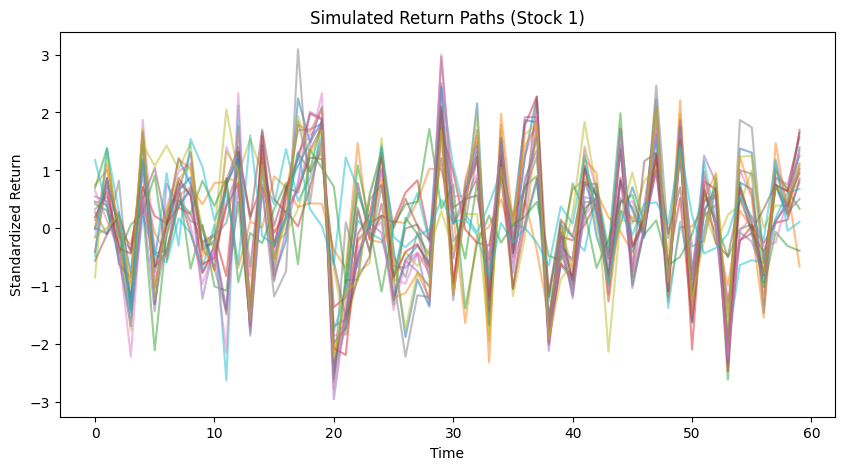

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Assume `returns_scaled` from Step 3.2 is ready (standardized log returns)
window_size = 60
input_dim = returns_scaled.shape[1]  # number of stocks
X = []

for i in range(len(returns_scaled) - window_size):
    X.append(returns_scaled.iloc[i:i + window_size].values)

X = np.array(X)
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = X_tensor.view(-1, window_size * input_dim)

# DataLoader
batch_size = 32
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Simple Diffusion Model (DDPM-style)
class SimpleDiffusion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )

    def forward(self, x, noise_level):
        return self.model(x) * noise_level + x * (1 - noise_level)

# Training setup
model = SimpleDiffusion(input_dim * window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()
num_epochs = 1000
num_timesteps = 100

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        x = batch[0]
        noise = torch.randn_like(x)
        t = torch.randint(1, num_timesteps, (x.size(0), 1), dtype=torch.float32) / num_timesteps
        noisy_x = x + noise * t
        out = model(noisy_x, t)
        loss = loss_fn(out, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# Generate synthetic scenarios
model.eval()
with torch.no_grad():
    simulated_paths = []
    for _ in range(100):  # generate 100 samples
        noise = torch.randn((1, window_size * input_dim))
        for t in reversed(range(1, num_timesteps + 1)):
            noise_level = torch.tensor(t / num_timesteps)
            noise = model(noise, noise_level)
        path = noise.view(window_size, input_dim).numpy()
        simulated_paths.append(path)

simulated_paths = np.array(simulated_paths)  # shape: (100, window_size, num_stocks)

# Plot simulation for one stock
plt.figure(figsize=(10, 5))
for i in range(20):
    plt.plot(simulated_paths[i, :, 0], alpha=0.5)
plt.title("Simulated Return Paths (Stock 1)")
plt.xlabel("Time")
plt.ylabel("Standardized Return")
plt.show()


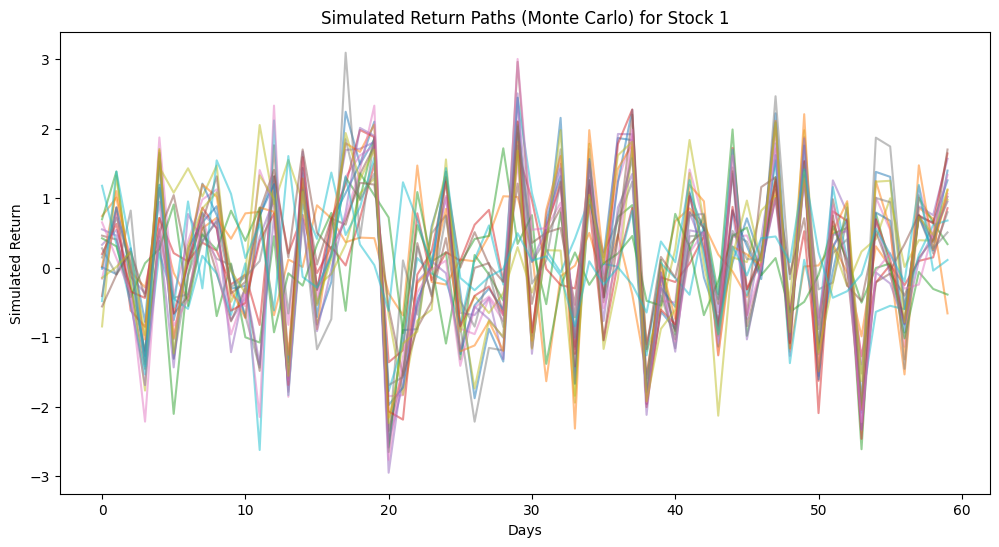

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(20):  # plot a few simulations
    plt.plot(simulated_paths[i, :, 0], alpha=0.5)  # example: 1st stock

plt.title("Simulated Return Paths (Monte Carlo) for Stock 1")
plt.xlabel("Days")
plt.ylabel("Simulated Return")
plt.show()


In [ ]:
scenario_returns = simulated_paths.mean(axis=1)
expected_returns = np.mean(scenario_returns, axis=0)
risk_matrix = np.cov(scenario_returns.T)


Real STD: 1.0003926958721954
Simulated STD: 0.5821492


C:\Users\Aditya Dwaraki Rao\AppData\Local\Temp\ipykernel_3476\3154147167.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Real STD:", real_vol[0])


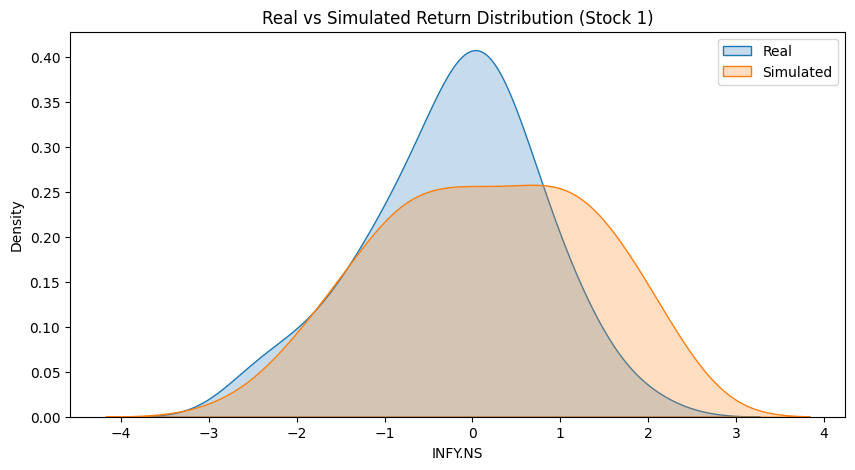

Epoch 1000: Loss = 7.1789
MSE (sim vs real): 2.3077992136292393
Avg covariance matrix diff: 0.15310080238105667


In [ ]:
# Compare volatility of real vs generated
real_vol = returns_scaled.std()
sim_vol = np.std(simulated_paths[:, :, 0], axis=0)  # for stock 1
print("Real STD:", real_vol[0])
print("Simulated STD:", np.mean(sim_vol))
# Plot distribution of real vs simulated
import seaborn as sns

plt.figure(figsize=(10,5))
sns.kdeplot(returns_scaled.iloc[-60:, 0], label='Real', fill=True)
sns.kdeplot(simulated_paths[0, :, 0], label='Simulated', fill=True)
plt.legend()
plt.title("Real vs Simulated Return Distribution (Stock 1)")
plt.show()
print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# Fix the MSE calculation by making sure sizes match
# Use only as many real data points as we have in the simulation for one path
sample_size = min(simulated_paths.shape[1], returns_scaled.shape[0])
mse = np.mean((simulated_paths[0, :sample_size, 0] - returns_scaled.iloc[-sample_size:, 0].values)**2)
print("MSE (sim vs real):", mse)

# Shape: (num_simulations, window_size, num_assets)
flattened = simulated_paths.reshape(-1, simulated_paths.shape[-1])
cov_sim = np.cov(flattened.T)

# Compare to real covariance
real_cov = returns_scaled.cov().values
diff = np.mean(np.abs(real_cov - cov_sim))
print("Avg covariance matrix diff:", diff)


